In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

clight = 2.99792458e10
planckh = 6.6260755e-27
kB = 1.38064852e-16
sigmaSB = 5.67051e-5

### Planck function and averaging over frequency

In [2]:
# planck function
def B_func(freq, temp):
    if planckh*freq/(kB*temp) < 1:
        exp = np.exp(planckh*freq/(kB*temp))
        return 2*planckh*freq**3/clight**2 * 1/(exp-1)
    else:
        exp = np.exp(-planckh*freq/(kB*temp))
        return 2*planckh*freq**3/clight**2 * exp/(1-exp)

# calculation of planck-mean opacity
def calc_planck_opac(lambda_grid, opac_grid, temp):
    # check lambda and opac grids are of same length
    if len(lambda_grid) != len(opac_grid):
        print("Error! Wavelength and opacity grid not of the same length in calc_planck_opac")
        import sys
        sys.exit()
    
    # frequency grid and Planck function values
    freq_grid = [clight/lam  for lam in lambda_grid]
    B_grid = [B_func(freq, temp) for freq in freq_grid]

    # integrate planck mean opacity
    integ_B = sigmaSB*temp**4/np.pi
    integ_Bk = 0
    for i in range(1, len(lambda_grid)):
        integ_Bk += 0.5 * (B_grid[i]*opac_grid[i]+B_grid[i-1]*opac_grid[i-1])*(freq_grid[i-1]-freq_grid[i])
    planck_opac = integ_Bk/integ_B

    # integrate planck mean opacity with half the step to check error
    integ_Bk = 0
    for i in range(2, len(lambda_grid), 2):
        integ_Bk += 0.5 * (B_grid[i]*opac_grid[i]+B_grid[i-2]*opac_grid[i-2])*(freq_grid[i-2]-freq_grid[i])
    error = abs(planck_opac-integ_Bk/integ_B)/planck_opac
    
    if error > 2e-2:
        print("Warning! Error in calc_planck_opac is %e" % error)
        plt.loglog(lambda_grid, opac_grid)
        plt.show()
        import sys
        sys.exit()

    return planck_opac

### Calculation of Planck-mean opacities

In [5]:
# set input files
#directory = 'corundum_K95'
#directory = 'enstatite_J98_J94_D95'
#directory = 'fayalite_F01'
#directory = 'graphite_D84'
#directory = 'olivine_F01'
directory = 'silicon_carbide_L93'
in_label = '_0.02'
out_label = '' # = in_label

# set temperature grid and stellar temperatures
temp_stellar = [4550, 3830]
temp_grid = np.logspace(np.log10(100), np.log10(2000), 210)

# read input
lambda_grid = np.loadtxt(directory+'/opac_wavelength.dat')
mie_abs_grid_all = np.loadtxt(directory+'/opac_mie_abs'+in_label+'.dat')
mie_sca_grid_all = np.loadtxt(directory+'/opac_mie_sca'+in_label+'.dat')
mie_gsc_grid_all = np.loadtxt(directory+'/opac_mie_gsc'+in_label+'.dat')

# save temperature grid to file
np.savetxt(directory+'/opac_temp.dat', temp_grid)

# calculate planck mean absorption
planck_grid_all = []
# iterate over sizes
for i, mie_abs_grid in zip(range(len(mie_abs_grid_all)), mie_abs_grid_all):
    # iterate over temperatures
    planck_grid = [calc_planck_opac(lambda_grid, mie_abs_grid, temp) for temp in temp_grid]
    planck_grid_all.append(planck_grid)
    #print( 'progress: %.1f' % ((i+1)/len(mie_abs_grid_all)*0.5*100), '%' )
    sys.stdout.write('\r progress: %.1f %%' % ((i+1)/len(mie_abs_grid_all)*0.5*100))
    sys.stdout.flush()
np.savetxt(directory+'/opac_planck_abs'+out_label+'.dat', planck_grid_all)

for temp in temp_stellar:
    planck_grid_all = []
    for mie_abs_grid in mie_abs_grid_all:
        planck_grid_all.append(calc_planck_opac(lambda_grid, mie_abs_grid, temp))
    np.savetxt(directory+'/opac_planck_abs_tstar%.0f' % temp +out_label+'.dat', planck_grid_all)

# weight the scattering coefficient by the g-factor
mie_sca_grid_all = (1-mie_gsc_grid_all)*mie_sca_grid_all
    
# calculate planck mean scattering
planck_grid_all = []
for i, mie_sca_grid in zip(range(len(mie_sca_grid_all)), mie_sca_grid_all):
    planck_grid = [calc_planck_opac(lambda_grid, mie_sca_grid, temp) for temp in temp_grid]
    planck_grid_all.append(planck_grid)
    #print( 'progress: %.1f' % ((i+1+len(mie_sca_grid_all))/len(mie_sca_grid_all)*0.5*100), '%' )
    sys.stdout.write('\r progress: %.1f %%' % ((i+1+len(mie_sca_grid_all))/len(mie_sca_grid_all)*0.5*100))
    sys.stdout.flush()
np.savetxt(directory+'/opac_planck_sca'+out_label+'.dat', planck_grid_all)

for temp in temp_stellar:
    planck_grid_all = []
    for mie_sca_grid in mie_sca_grid_all:
        planck_grid_all.append(calc_planck_opac(lambda_grid, mie_sca_grid, temp))
    np.savetxt(directory+'/opac_planck_sca_tstar%.0f' % temp +out_label+'.dat', planck_grid_all)

 progress: 100.0 %

### Plotting Planck-mean opacities

Different materials for a fixed grain size

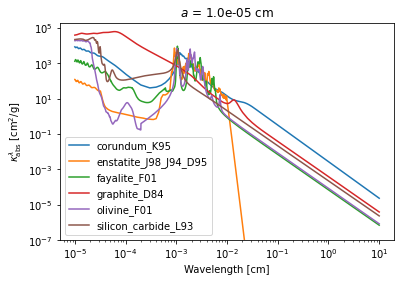

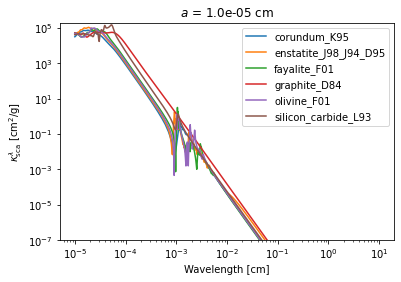

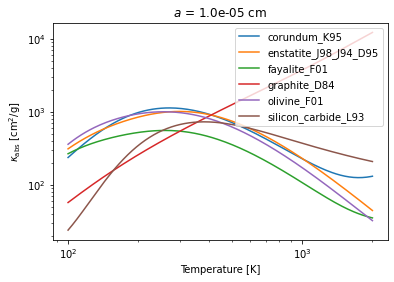

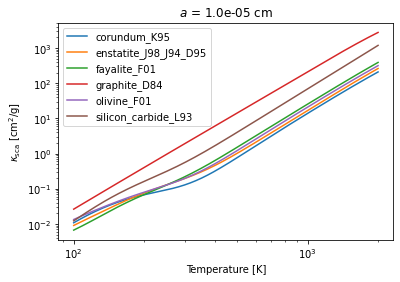

In [18]:
size_index = 0

for kappa in ['abs', 'sca']:
    sarr = []
    for directory in ['corundum_K95','enstatite_J98_J94_D95','fayalite_F01','graphite_D84','olivine_F01','silicon_carbide_L93']:
        label = '_0.02'

        sizes = np.loadtxt(directory+'/opac_sizes.dat')
        lam = np.loadtxt(directory+'/opac_wavelength.dat')
        opac_in = np.loadtxt(directory+'/opac_mie_'+kappa+label+'.dat')

        i = size_index
        sarr.append(sizes[i])
        plt.loglog(lam, opac_in[i,:], label=directory)
        plt.title(r'$a$ = %.1e cm' % sizes[i])

    plt.ylim(1e-7, 2e5)
    plt.xlabel('Wavelength [cm]')
    plt.ylabel(r'$\kappa_{\rm'+kappa+'}^\lambda$ [cm$^2$/g]')
    plt.legend()
    plt.show()

for kappa in ['abs', 'sca']:
    sarr = []
    for directory in ['corundum_K95','enstatite_J98_J94_D95','fayalite_F01','graphite_D84','olivine_F01','silicon_carbide_L93']:
        label = ''

        sizes = np.loadtxt(directory+'/opac_sizes.dat')
        temp = np.loadtxt(directory+'/opac_temp.dat')
        planck_in = np.loadtxt(directory+'/opac_planck_'+kappa+label+'.dat')

        i = size_index
        sarr.append(sizes[i])
        plt.loglog(temp, planck_in[i,:], label=directory)
        plt.title(r'$a$ = %.1e cm' % sizes[i])

    plt.xlabel('Temperature [K]')
    plt.ylabel(r'$\kappa_{\rm'+kappa+'}$ [cm$^2$/g]')
    plt.legend()
    plt.show()

Comparison of opacities calculated with logawidth = 0.02 and logawidth = 0.1

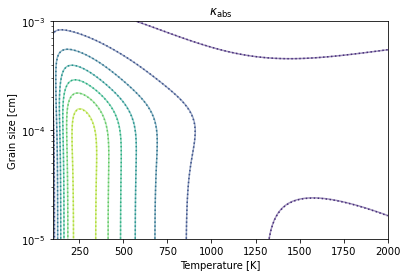

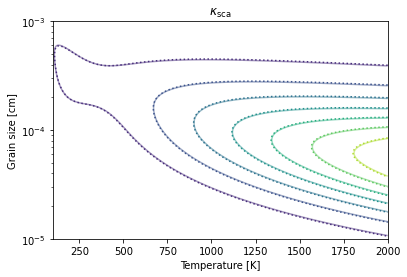

In [18]:
directory = 'corundum_K95'

sizes = np.loadtxt(directory+'/opac_sizes.dat')
temp = np.loadtxt(directory+'/opac_temp.dat')

label = ''
planck_abs_1 = np.loadtxt(directory+'/opac_planck_abs'+label+'.dat')
planck_sca_1 = np.loadtxt(directory+'/opac_planck_sca'+label+'.dat')
label = '_0.1'
planck_abs_2 = np.loadtxt(directory+'/opac_planck_abs'+label+'.dat')
planck_sca_2 = np.loadtxt(directory+'/opac_planck_sca'+label+'.dat')

plt.contour(temp, sizes, planck_abs_1, alpha=0.5)
plt.contour(temp, sizes, planck_abs_2, linestyles=':')
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Grain size [cm]')
plt.title(r'$\kappa_{\rm abs}$')
plt.show()

plt.contour(temp, sizes, planck_sca_1, alpha=0.5)
plt.contour(temp, sizes, planck_sca_2, linestyles=':')
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Grain size [cm]')
plt.title(r'$\kappa_{\rm sca}$')
plt.show()